In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg

In [15]:
def duffing_sde(n_timesteps, dt, alpha, sigma_q=1.0, m_0=np.zeros(2), P_0=np.eye(2), sub_step=10):    
    t_T = np.zeros(n_timesteps + 1)
    x_T = np.zeros((n_timesteps + 1, 2))
    
    x_T[0] = np.random.multivariate_normal(m_0, P_0)
    d_dt = dt / sub_step
    
    for t in range(1, n_timesteps + 1):
        x_int = x_T[t - 1]
        
        for _ in range(sub_step):
            eps_t = np.random.multivariate_normal(np.zeros(2), sigma_q * sigma_q * d_dt * np.eye(2))
            f_vec = np.array([x_int[1], x_int[0] * (alpha - x_int[0] ** 2) - x_int[1]])
            L = np.array([[0, 0], [x_int[0], 0]])

            dx_t = f_vec * d_dt + np.matmul(L, eps_t)
            
            x_int = x_int + dx_t
            
        x_T[t] = x_int
        t_T[t] = t_T[t - 1] + dt
    
    return x_T, t_T

In [16]:
def observation_model(x_T, sigma_r=1.0):
    H = np.array([1, 0]).reshape((1, 2))
        
    y_T = np.zeros(len(x_T) - 1)
    for t in range(len(x_T) - 1):
        y_T[t] = np.matmul(H, x_T[t + 1]) + np.random.randn() * sigma_r
    
    return y_T

In [17]:
def sde_ekf(y_T, dt, alpha, sigma_q=1.0, sigma_r=1.0, m_0=np.zeros(2), P_0=np.eye(2), sub_step=10):
    H = np.array([1, 0]).reshape(1, 2)
    Q = sigma_q * sigma_q * np.eye(2)
    
    m_prev = m_0
    P_prev = P_0
    
    m_filter = np.zeros((len(y_T), 2))
    P_filter = np.zeros((len(y_T), 2, 2))
    
    for t in range(len(y_T)):
        # Prediction Step: Numerical Integration
        m_int = m_prev
        P_int = P_prev
        d_dt = dt / sub_step
        for _ in range(sub_step):
            increment_m = np.array([m_int[1], m_int[0] * (alpha - m_int[0] ** 2) - m_int[1]])
            
            F_x = np.array([[0, 1], [alpha - 3 * m_int[0] ** 2, -1]])
            
            L = np.array([[0, 0], [m_int[0], 0]])
            increment_P = np.matmul(F_x, P_int) + np.matmul(P_int, F_x.T) + np.matmul(np.matmul(L, Q), L.T)
            
            m_int = m_int + increment_m * d_dt
            P_int = P_int + increment_P * d_dt

        # Update Step
        v = y_T[t] - np.matmul(H, m_int)
        S = np.matmul(H, np.matmul(P_int, H.T)) + sigma_r ** 2
        K = np.matmul(P_int, H.T) / S
        
        m_prev = m_int + np.matmul(K, v)
        P_prev = P_int - np.matmul(K, np.matmul(S, K.T))
        
        m_filter[t] = m_prev
        P_filter[t] = P_prev
    
    return m_filter, P_filter

In [18]:
def sde_ckf(y_T, dt, alpha, sigma_q=1.0, sigma_r=1.0, m_0=np.zeros(2), P_0=np.eye(2), sub_step=10):
    H = np.array([1, 0]).reshape(1, 2)
    Q = sigma_q * sigma_q * np.eye(2)
    n_dim = 2

    m_prev = m_0.reshape((n_dim, 1))
    P_prev = P_0
    
    m_filter = np.zeros((len(y_T), n_dim, 1))
    P_filter = np.zeros((len(y_T), n_dim, 2))
    
    
    for t in range(len(y_T)):
        # Prediction Step: Numerical Integration
        m_int = m_prev
        P_int = P_prev
        d_dt = dt / sub_step
        
        for step in range(sub_step):
            chol_P_int = np.linalg.cholesky(P_int)
            
            increment_m = np.zeros((n_dim, 1))
            increment_P = np.zeros((n_dim, n_dim))
            
            for n_sigma in range(1, 2 * n_dim + 1):
                basis = np.zeros(n_dim)
                if n_sigma > n_dim:
                    basis[n_sigma - n_dim - 1] = -1.0 * np.sqrt(n_dim)
                else:
                    basis[n_sigma - 1] = np.sqrt(n_dim)
                
                basis = basis.reshape((n_dim,1))
                sigma_pt = m_int + np.matmul(chol_P_int, basis)
                
                sigma_pt_r = sigma_pt.reshape((n_dim,))
                f_sigma = np.array([sigma_pt_r[1], sigma_pt_r[0] * (alpha - sigma_pt_r[0] ** 2) - sigma_pt_r[1]]).reshape((2, 1))
                
                increment_m = increment_m + f_sigma / (2 * n_dim)
                mul_P_factor = np.matmul(f_sigma, np.matmul(basis.T, chol_P_int.T))
                
                L = np.array([[0, 0], [m_int[0], 0]])
                var_factor = np.matmul(L, np.matmul(Q, L.T))
                increment_P = increment_P + (mul_P_factor + mul_P_factor.T + var_factor) / (2 * n_dim)
            
            m_int = m_int + increment_m * d_dt
            P_int = P_int + increment_P * d_dt

        # Update Step
        v = y_T[t] - np.matmul(H, m_int)
        S = np.matmul(H, np.matmul(P_int, H.T)) + sigma_r ** 2
        K = np.matmul(P_int, H.T) / S
        
        m_prev = m_int + np.matmul(K, v)
        P_prev = P_int - np.matmul(K, np.matmul(S, K.T))
        
        m_filter[t] = m_prev
        P_filter[t] = P_prev
    
    m_filter = m_filter.reshape((len(y_T), 2))
    
    return m_filter, P_filter

In [19]:
n_timesteps = 1000
dt = 0.01
alpha = 2
sigma_q = 1.0
sigma_r = 1.0
m_0 = np.zeros(2)
P_0 = np.eye(2)
sub_step = 10

In [20]:
x_T, t_T = duffing_sde(n_timesteps, dt, alpha, sigma_q, m_0, P_0, sub_step)
y_T = observation_model(x_T, sigma_r)

In [21]:
m_ekf, P_ekf = sde_ekf(y_T, dt, alpha, sigma_q, sigma_r, m_0, P_0, sub_step)
m_ckf, P_ckf = sde_ckf(y_T, dt, alpha, sigma_q, sigma_r, m_0, P_0, sub_step)

In [22]:
rms_baseline = np.mean((x_T[1:, 0] - y_T) ** 2)
rms_ekf = np.mean((x_T[1:, 0] - m_ekf[:, 0]) ** 2)
rms_ckf = np.mean((x_T[1:, 0] - m_ckf[:, 0]) ** 2)

print('Baseline RMSE : {}'.format(rms_baseline))
print('EKF RMSE : {}'.format(rms_ekf))
print('CKF RMSE : {}'.format(rms_ckf))

Baseline RMSE : 0.9220997726208604
EKF RMSE : 0.04405709665539992
CKF RMSE : 0.045478334721785404


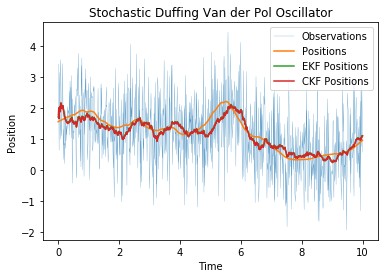

In [23]:
plt.plot(t_T[1:], y_T, linewidth=0.2, label='Observations')
plt.plot(t_T, x_T[:, 0], label='Positions')
plt.plot(t_T[1:], m_ekf[:, 0], label='EKF Positions')
plt.plot(t_T[1:], m_ckf[:, 0], label='CKF Positions')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Stochastic Duffing Van der Pol Oscillator')
plt.legend()

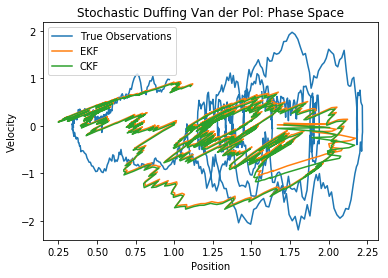

In [24]:
plt.plot(x_T[:, 0], x_T[:, 1], label='True Observations')
plt.plot(m_ekf[:, 0], m_ekf[:, 1], label='EKF')
plt.plot(m_ckf[:, 0], m_ckf[:, 1], label='CKF')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Stochastic Duffing Van der Pol: Phase Space')
plt.legend()

In [26]:
import tqdm
n_rep = 10
rms_b = 0.0
rms_c = 0.0
rms_e = 0.0

for _ in tqdm.tqdm(range(n_rep)):
    x_T, t_T = duffing_sde(n_timesteps, dt, alpha, sigma_q, m_0, P_0, sub_step)
    y_T = observation_model(x_T, sigma_r)
    m_ekf, P_ekf = sde_ekf(y_T, dt, alpha, sigma_q, sigma_r, m_0, P_0, sub_step)
    m_ckf, P_ckf = sde_ckf(y_T, dt, alpha, sigma_q, sigma_r, m_0, P_0, sub_step)
    rms_b += np.mean((x_T[1:, 0] - y_T) ** 2)
    rms_e += np.mean((x_T[1:, 0] - m_ekf[:, 0]) ** 2)
    rms_c += np.mean((x_T[1:, 0] - m_ckf[:, 0]) ** 2)

print(rms_b / 10.0, rms_e / 10.0, rms_c / 10.0)


100%|██████████| 10/10 [00:22<00:00,  2.29s/it]


0.9941668901831744 0.03523624022343604 0.03510275274523184
